## 1. Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Data

In [4]:
from PIL import Image
import torchvision.transforms as transforms

imsize = 256
img_transforms = transforms.Compose([
    transforms.Resize((imsize, imsize)), 
    transforms.ToTensor()
])

In [5]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = img_transforms(image).unsqueeze(0)
    return image.to(device, torch.float)

content_img = image_loader("content_img.jpg")

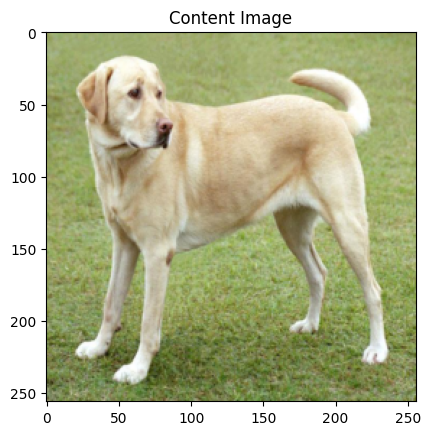

In [6]:
unloader = transforms.ToPILImage() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone() 
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


plt.figure()
imshow(content_img, title='Content Image')

## 3. Loss Functions

In [7]:
ContentLoss = nn.L1Loss()

## 3. Model

In [8]:
from torchvision.models import vgg19, VGG19_Weights

VGG19_pretrained = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
for param in VGG19_pretrained.parameters():
    param.requires_grad_(False)

VGG19_pretrained.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
def get_features(pretrained_model, image):
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }
    features = {}
    x = image
    for name, pretrained_layer in pretrained_model._modules.items():
        x = pretrained_layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [10]:
content_features = get_features(VGG19_pretrained, content_img)

## 4. Training

In [11]:
import torch.optim as optim

target_img = torch.rand(content_img.shape).to(device)
target_img = target_img.requires_grad_(True)
optimizer = optim.Adam([target_img], lr=0.02)

In [12]:
STEPS = 100

for step in range(STEPS):
    optimizer.zero_grad()
    target_features = get_features(VGG19_pretrained, target_img)
    content_loss = ContentLoss(content_features['conv_1'], target_features['conv_1'])
    content_loss.backward()
    optimizer.step()

    with torch.no_grad():
        target_img.clamp_(0, 1)
    
    if step % 10 == 0:
        print(f"Epoch [{step+1}/{STEPS}] Content loss: {content_loss.item():.6f}")
        
        fname = '7.L1_conv1/at_%d.png' % (step+1)
        print(target_img[0].detach().cpu().permute(1, 2, 0).numpy().shape)
        mpl.image.imsave(fname, target_img[0].detach().cpu().permute(1, 2, 0).numpy())

Epoch [1/100] Content loss: 0.192244
(256, 256, 3)
Epoch [11/100] Content loss: 0.090665
(256, 256, 3)
Epoch [21/100] Content loss: 0.046076
(256, 256, 3)
Epoch [31/100] Content loss: 0.028431
(256, 256, 3)
Epoch [41/100] Content loss: 0.017742
(256, 256, 3)
Epoch [51/100] Content loss: 0.011640
(256, 256, 3)
Epoch [61/100] Content loss: 0.008071
(256, 256, 3)
Epoch [71/100] Content loss: 0.005814
(256, 256, 3)
Epoch [81/100] Content loss: 0.004519
(256, 256, 3)
Epoch [91/100] Content loss: 0.003805
(256, 256, 3)


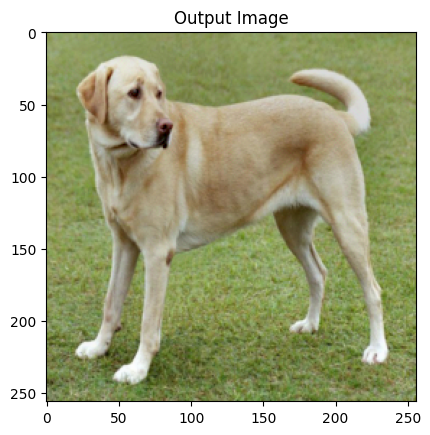

In [13]:
plt.figure()
imshow(target_img.detach(), title='Output Image')
plt.show()